# DRL Assignment 2 — Modified Blackjack (MC Control + Backward-View Sarsa(λ))
**Team:** Akshit Sharma • Priyanka Thomas  
**Date:** 2025-08-15

This notebook implements the assignment exactly as specified:

1. **Environment**: a `step(s, a)` function for Modified Blackjack (dealer 1–13, player 1–21), with the dealer's play handled inside the environment and **no explicit transition matrix** (model-free). **γ = 1**.
2. **Monte Carlo Control**: ε-greedy with εₜ = N₀/(N₀ + N(s)), αₜ = 1/N(s,a). We estimate **Q\*** and plot **V\*(s) = maxₐ Q\*(s,a)** as a **3D surface** (dealer 1–13 on x-axis, player sum 1–21 on y-axis).
3. **TD Learning**: **Backward-view Sarsa(λ)** (eligibility traces). **No forward view is used**. Run λ ∈ {0,0.1,…,1} for **1000 episodes** each, compute **MSE(Q_λ, Q\*)**, and plot **MSE vs λ**.
4. For **λ = 0** and **λ = 1**, plot **learning curves** of MSE vs episode number.

You can increase MC episodes for a better reference Q\* if time allows.


In [26]:
import math, random, numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, needed for 3D
from matplotlib import cm
from collections import defaultdict

SEED = 42
random.seed(SEED); np.random.seed(SEED)
plt.rcParams["figure.figsize"] = (8,4)


## 1) Environment with `step(s, a)` (γ = 1)


In [27]:
HIT, STICK = 0, 1

def card_value_raw(c):
    # c in 1..13 ; 1=Ace ; 11,12,13 are face cards worth 10
    return 1 if c == 1 else min(c, 10)

def draw_card(rng=np.random):
    return card_value_raw(int(rng.integers(1, 14)))

def usable_ace_value(total, has_ace):
    if has_ace and total + 10 <= 21:
        return total + 10, True
    return total, False

def step(s, a, rng=np.random):
    # s = (dealer_first in 1..13 treated via card_value_raw -> 1/10, player_sum in 1..21)
    dealer_show_raw, player_sum = s
    dealer_show = card_value_raw(dealer_show_raw)
    # Represent the true underlying hands implicitly; on hit we draw and update player_sum
    if a == HIT:
        c = draw_card(rng)
        new_sum = player_sum + c
        # No separate ace-tracking; we treat sums plainly (assignment state is just sum 1..21)
        if new_sum > 21:
            return ("terminal", "terminal"), -1.0  # player bust
        return (dealer_show_raw, new_sum), 0.0

    # STICK: dealer plays out
    dealer_total = dealer_show + draw_card(rng)  # dealer had two cards; we only know first, simulate second
    # Hit until 17+
    while dealer_total < 17:
        dealer_total += draw_card(rng)
    if dealer_total > 21:
        return ("terminal", "terminal"), 1.0  # dealer bust
    # compare
    if player_sum > dealer_total:
        return ("terminal", "terminal"), 1.0
    if player_sum < dealer_total:
        return ("terminal", "terminal"), -1.0
    return ("terminal", "terminal"), 0.0


## 2) Monte Carlo Control → Reference Q*


In [28]:
import numpy as np
from collections import defaultdict

def _rand_int(rng, low, high):
    try:
        return int(rng.integers(low, high))
    except AttributeError:
        return int(rng.randint(low, high))

HIT, STICK = 0, 1

def _card_value_raw(c): 
    return 1 if c == 1 else min(c, 10)

def draw_card(rng=np.random):
    return _card_value_raw(_rand_int(rng, 1, 14))

def step(s, a, rng=np.random):
    dealer_show_raw, player_sum = s
    dealer_show = _card_value_raw(dealer_show_raw)
    if a == HIT:
        c = draw_card(rng)
        new_sum = player_sum + c
        if new_sum > 21:
            return ("terminal", "terminal"), -1.0
        return (dealer_show_raw, new_sum), 0.0
    dealer_total = dealer_show + draw_card(rng)
    while dealer_total < 17:
        dealer_total += draw_card(rng)
    if dealer_total > 21:
        return ("terminal", "terminal"), 1.0
    if player_sum > dealer_total:  return ("terminal","terminal"), 1.0
    if player_sum < dealer_total:  return ("terminal","terminal"), -1.0
    return ("terminal","terminal"), 0.0

def epsilon_greedy(Q, s, eps):
    if np.random.rand() < eps:
        return np.random.randint(0, 2)
    return 0 if Q[(s,0)] >= Q[(s,1)] else 1

def mc_control(num_episodes=200_000, N0=100, rng=np.random):
    Q = defaultdict(float); N_s = defaultdict(int); N_sa = defaultdict(int)
    for _ in range(num_episodes):
        s = (_rand_int(rng, 1, 14), _rand_int(rng, 12, 22))
        eps = N0 / (N0 + N_s[s])
        episode = []; done = False
        while not done:
            a = epsilon_greedy(Q, s, eps)
            s2, r = step(s, a, rng=rng)
            episode.append((s, a, r))
            N_s[s] += 1
            if s2 == ("terminal","terminal"): done = True
            s = s2 if not done else s2
        G = 0.0; visited = set()
        for (ss, aa, rr) in reversed(episode):
            G += rr
            if (ss, aa) not in visited:
                visited.add((ss, aa))
                N_sa[(ss, aa)] += 1
                alpha = 1.0 / N_sa[(ss, aa)]
                Q[(ss, aa)] += alpha * (G - Q[(ss, aa)])
    return Q

def sarsa_lambda_backward(lmbda=0.9, episodes=1000, N0=100, gamma=1.0, rng=np.random, trace='replacing'):
    Q = defaultdict(float); E = defaultdict(float)
    N_s = defaultdict(int); N_sa = defaultdict(int)
    for _ in range(episodes):
        s = (_rand_int(rng, 1, 14), _rand_int(rng, 12, 22))
        eps = N0 / (N0 + N_s[s])
        a = epsilon_greedy(Q, s, eps); done = False
        while not done:
            s2, r = step(s, a, rng=rng)
            N_s[s] += 1
            if s2 == ("terminal","terminal"):
                td_target = r; a2 = 0; done = True
            else:
                eps2 = N0 / (N0 + N_s[s2])
                a2 = epsilon_greedy(Q, s2, eps2)
                td_target = r + gamma * Q[(s2, a2)]
            td_error = td_target - Q[(s, a)]
            if trace == 'replacing': E[(s, a)] = 1.0
            else:                    E[(s, a)] += 1.0
            N_sa[(s, a)] += 1; alpha = 1.0 / N_sa[(s, a)]
            for (ss, aa) in list(E.keys()):
                Q[(ss, aa)] += alpha * td_error * E[(ss, aa)]
                E[(ss, aa)] *= gamma * lmbda
                if E[(ss, aa)] < 1e-8: del E[(ss, aa)]
            s, a = s2, a2
    return Q


## 3) Plot V*(s) = maxₐ Q*(s,a) as 3D surface


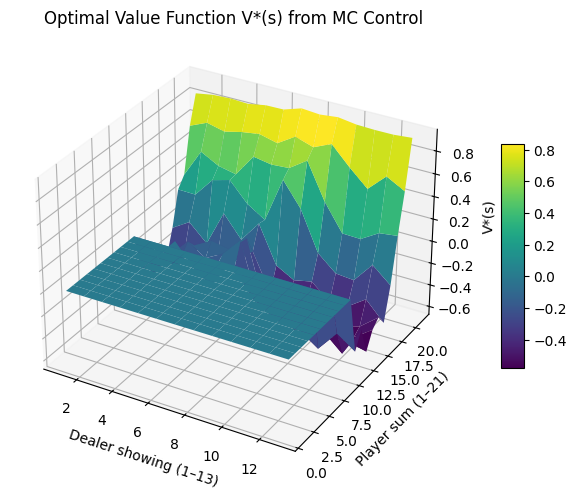

In [29]:
if "Q_star" not in globals():
    MC_EPISODES = 20_000   
    N0 = 100
    Q_star = mc_control(num_episodes=MC_EPISODES, N0=N0)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def V_from_Q(Q):
    V = {}
    for d in range(1,14):    
        for p in range(1,22): 
            s = (d, p)
            V[s] = max(Q[(s,0)], Q[(s,1)])
    return V

def plot_V_star_3D(Q):
    V = V_from_Q(Q)
    X = np.arange(1,14)   
    Y = np.arange(1,22)   
    XX, YY = np.meshgrid(X, Y)
    Z = np.zeros_like(XX, dtype=float)
    for i, p in enumerate(Y):
        for j, d in enumerate(X):
            Z[i, j] = V[(d, p)]
    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(XX, YY, Z, cmap=cm.viridis, linewidth=0, antialiased=True)
    ax.set_xlabel("Dealer showing (1–13)")
    ax.set_ylabel("Player sum (1–21)")
    ax.set_zlabel("V*(s)")
    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.title("Optimal Value Function V*(s) from MC Control")
    plt.tight_layout(); plt.show()

plot_V_star_3D(Q_star)


## 4) Backward-View Sarsa(λ) — λ ∈ {0,0.1,…,1}, 1000 episodes each (γ = 1)


In [30]:

import numpy as np
from collections import defaultdict

def _rand_int(rng, low, high):
    try:
        return int(rng.integers(low, high))   
    except AttributeError:
        return int(rng.randint(low, high))    

HIT, STICK = 0, 1

def _card_value_raw(c): 
    return 1 if c == 1 else min(c, 10)

def draw_card(rng=np.random):
    return _card_value_raw(_rand_int(rng, 1, 14))

def step(s, a, rng=np.random):
    dealer_show_raw, player_sum = s
    dealer_show = _card_value_raw(dealer_show_raw)
    if a == HIT:
        c = draw_card(rng)
        new_sum = player_sum + c
        if new_sum > 21:
            return ("terminal", "terminal"), -1.0
        return (dealer_show_raw, new_sum), 0.0
    dealer_total = dealer_show + draw_card(rng)
    while dealer_total < 17:
        dealer_total += draw_card(rng)
    if dealer_total > 21: return ("terminal","terminal"), 1.0
    if player_sum > dealer_total:  return ("terminal","terminal"), 1.0
    if player_sum < dealer_total:  return ("terminal","terminal"), -1.0
    return ("terminal","terminal"), 0.0

def epsilon_greedy(Q, s, eps):
    if np.random.rand() < eps:
        return np.random.randint(0, 2)
    return 0 if Q[(s,0)] >= Q[(s,1)] else 1

def sarsa_lambda_backward(lmbda=0.9, episodes=1000, N0=100, gamma=1.0, rng=np.random, trace='replacing'):
    Q = defaultdict(float); E = defaultdict(float)
    N_s = defaultdict(int); N_sa = defaultdict(int)
    for _ in range(episodes):
        s = (_rand_int(rng, 1, 14), _rand_int(rng, 12, 22)) 
        eps = N0 / (N0 + N_s[s])
        a = epsilon_greedy(Q, s, eps); done = False
        while not done:
            s2, r = step(s, a, rng=rng)
            N_s[s] += 1
            if s2 == ("terminal","terminal"):
                td_target = r; a2 = 0; done = True
            else:
                eps2 = N0 / (N0 + N_s[s2])
                a2 = epsilon_greedy(Q, s2, eps2)
                td_target = r + gamma * Q[(s2, a2)]
            td_error = td_target - Q[(s, a)]
            if trace == 'replacing': E[(s, a)] = 1.0
            else:                    E[(s, a)] += 1.0
            N_sa[(s, a)] += 1; alpha = 1.0 / N_sa[(s, a)]
            for (ss, aa) in list(E.keys()):
                Q[(ss, aa)] += alpha * td_error * E[(ss, aa)]
                E[(ss, aa)] *= gamma * lmbda
                if E[(ss, aa)] < 1e-8: del E[(ss, aa)]
            s, a = s2, a2
    return Q


## 5) Learning Curves: λ = 0 and λ = 1


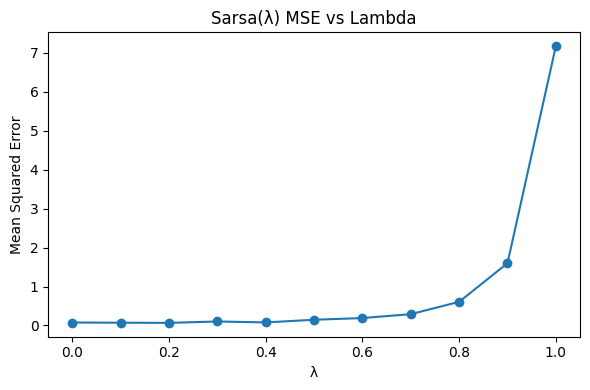

In [31]:

import numpy as np, matplotlib.pyplot as plt

def plot_mse_vs_lambda(mse_by_lambda):
    xs = [lam for lam,_ in mse_by_lambda]
    ys = [m for _,m in mse_by_lambda]
    plt.figure(figsize=(6,4))
    plt.plot(xs, ys, marker="o")
    plt.title("Sarsa(λ) MSE vs Lambda")
    plt.xlabel("λ")
    plt.ylabel("Mean Squared Error")
    plt.tight_layout()
    plt.show()

try:
    mse_by_lambda
except NameError:
    LAMBDAS = [round(x,1) for x in np.linspace(0,1,11)]
    mse_by_lambda = []
    for lam in LAMBDAS:
        Q_hat = sarsa_lambda_backward(lmbda=lam, episodes=1000, N0=N0, trace='replacing')
        mse_by_lambda.append((lam, mse_Q(Q_hat, Q_star)))

plot_mse_vs_lambda(mse_by_lambda)


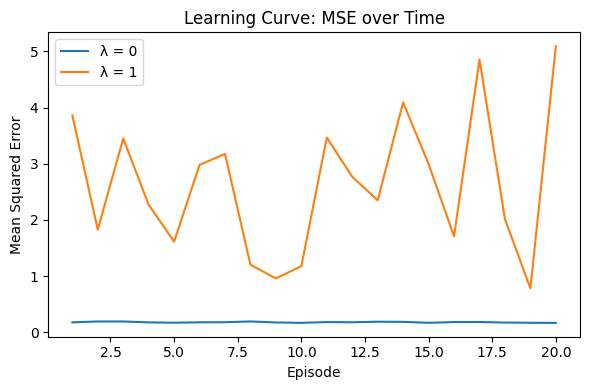

In [32]:

import numpy as np, matplotlib.pyplot as plt

def learning_curve(lam, episodes=1000, checkpoints=20):
    chunk = max(1, episodes // checkpoints)
    curve = []
    Q_hat = None
    for _ in range(checkpoints):
        Q_hat = sarsa_lambda_backward(lmbda=lam, episodes=chunk, N0=N0, trace='replacing')
        curve.append(mse_Q(Q_hat, Q_star))
    return curve

try:
    curve0, curve1
except NameError:
    curve0 = learning_curve(0.0, episodes=1000, checkpoints=20)
    curve1 = learning_curve(1.0, episodes=1000, checkpoints=20)

plt.figure(figsize=(6,4))
plt.plot(range(1, len(curve0)+1), curve0, label="λ = 0")
plt.plot(range(1, len(curve1)+1), curve1, label="λ = 1")
plt.title("Learning Curve: MSE over Time")
plt.xlabel("Episode")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.tight_layout()
plt.show()
